# Keras Tutorial #
# Convolutional Neural Networks

## Introduction

In this tutorial, you are going to implement a simple Convolutional Neural Network in Keras.

Convolutional Networks work by moving small filters across the input image. This means the filters are re-used for recognizing patterns throughout the entire input image. This makes the Convolutional Networks much more powerful than Fully Connected networks with the same number of variables. This in turn makes the Convolutional Networks faster to train.

If you are using Google Colab, run the following cell to mount your Google Drive

In [1]:
# if 'google.colab' in str(get_ipython()):
#     print('Running on CoLab')
#     import os
#     from google.colab import drive
#     drive.mount('/content/drive')
#     predefined_path = 'drive/MyDrive'  
#     my_path = ''  # place the path to your notebook in Google Drive
#     os.chdir(os.path.join(predefined_path, my_path))

## Flowchart
The following chart shows the structure of the Convolutional Neural Network implemented below.

![](https://drive.google.com/uc?id=140yiEyYl4rr6_zLRzHzpnWqukOuQCh3j)
The input image is processed in the first convolutional layer using the filter-weights. This results in 16 new images, one for each filter in the convolutional layer. The images are also downsampled thus reducing the image resolution from 28x28 to 14x14.

These 16 smaller images are then processed in the second convolutional layer. We need filter-weights for each of these 16 channels, and we need filter-weights for each output channel of this layer. There are 36 output channels so there are a total of 16 x 36 = 576 filters in the second convolutional layer. The resulting images are downsampled again to 7x7 pixels.

The output of the second convolutional layer is composed by 36 images of 7x7 pixels each. These are then flattened to a single vector of length 7 x 7 x 36 = 1764, which is used as the input to a fully connected layer with 128 neurons (or elements). This feeds into another fully connected layer with 10 neurons, one for each of the classes, which is used to determine the class of the image, that is, which number is depicted in the image.

The convolutional filters are initially chosen at random, so the classification is done randomly. The error between the predicted and true class of the input image is measured using the cross-entropy. The optimizer then automatically propagates this error back through the Convolutional Network using the chain-rule of differentiation and updates the filter-weights so as to improve the classification error. This is done iteratively thousands of times until the classification error is sufficiently low.

These particular filter-weights and intermediate images are the results of one optimization run and may look different if you re-run this Notebook.

Note that the computation in Keras is actually done on a batch of images instead of a single image, which makes the computation more efficient. This means the flowchart actually has one more data-dimension when implemented in Keras.

## Imports

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import math

from tensorflow.math import confusion_matrix

!pip list

Package                       Version
----------------------------- ---------
absl-py                       1.4.0
asttokens                     2.1.0
astunparse                    1.6.3
attrs                         21.2.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
brotlipy                      0.7.0
cachetools                    5.2.1
certifi                       2022.12.7
cffi                          1.15.1
charset-normalizer            2.0.4
colorama                      0.4.6
conda                         22.11.1
conda-package-handling        1.9.0
contourpy                     1.0.7
cryptography                  38.0.1
cycler                        0.11.0
debugpy                       1.6.3
decorator                     5.1.1
dill                          0.3.4
dlx                           1.0.4
docplex                       2.22.213
entrypoints                   0.4
executing                     1.2.0
fastdtw                       0.3.4
fastjsonsch

This was developed using Python 3.6 and TensorFlow version:

In [3]:
tf.__version__

'2.10.1'

## Load Data

We are going to use the fashion MNIST dataset. It will be downloaded automatically if it is not located in the given path.

In [4]:
mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

The MNIST dataset has now been loaded and consists of 70.000 images and class-numbers for the images. The dataset is split into 2 mutually exclusive sub-sets.

In [5]:
print("Size of:")
print("- Training-set:\t\t{}".format(train_images.shape[0]))
print("- Test-set:\t\t{}".format(test_images.shape[0]))

Size of:
- Training-set:		60000
- Test-set:		10000


Each image contained in the dataset is represented in a vectorized (1D) form. We will reshape them to standard 2D images.

In [6]:
# We know that MNIST images are composed by 28 pixels in each dimension.
img_shape = 28

# Reshape MNIST images 
train_images = train_images.reshape((-1, img_shape, img_shape, 1), order="F")
test_images = test_images.reshape((-1, img_shape, img_shape, 1), order="F")

The loaded images have values in the range [0; 255].
We normalize them in the range [0; 1].

In [7]:
# Preprocessing
train_images = train_images / 255.0
test_images = test_images / 255.0

### Label Encoding

The class labels are stored as a list of integers ranging from 0 to 9. These are the numbers associated to the images. The $i-th$ element in train_labels is the label related to the $i-th$ image in train_images (train_images[i]). test_images and test_labels have a similar structure.

In [8]:
# Number of classes and relative names
num_classes = 10
class_names = ['Tsh.', 'Trous.', 'Pull.', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneak.', 'Bag', 'A.boot']

train_labels[0:5]

array([9, 0, 0, 3, 0], dtype=uint8)

### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [9]:
def plot_images(images, labels, predictions=None):
    assert len(images) == len(labels) == 9
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].squeeze(), cmap='binary')
        # Show true and predicted classes.
        if predictions is None:
            xlabel = "True: {0}".format(class_names[labels[i]])
        else:
            xlabel = "True: {0}, Pred: {1}".format(class_names[labels[i]], class_names[predictions[i]])
        ax.set_xlabel(xlabel)
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

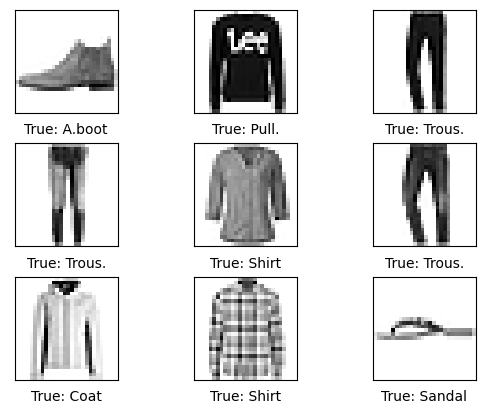

In [10]:
# Get the first images from the test-set.
images = test_images[0:9]

# Get the true classes for those images.
cls_true = test_labels[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, labels=cls_true)

## Build the Classification Model

Building the neural network requires configuring the layers of the model, then compiling it.

### Input Tensor

First, we allocate a Keras tensor that is going to contain the input data.

The input is assumed to be a 3D tensor of shape [num_inputs1, num_inputs2, 1].
The third dimension is 1 because we are dealing with grayscale images. It would be 3 for a color image.

In [11]:
input = keras.layers.Input(shape=(img_shape, img_shape, 1)) 

### Setup the Layers
The presented neural network is composed by 2 convolutional layers, each one followed by a 2x2 max pooling layer, and 2 fully connected (dense) layers.

Here, it is possible to change some parameters related to the layers.

In [12]:
# feel free to change sizes and number of filters to see what happens !!!

# Convolutional Layer 1.
kernel_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

# The output fully connected layer is composed by 10 neurons as the number of classes we are going to use

Now, we can start to setup our network.

The first layer that we are going to add is a convolution layer. This is going to be applied on the `input` tensor.
It is composed by `num_filters1` different filters, each having width and height equal to `kernel_size1`.

In [13]:
conv1 = keras.layers.Conv2D(filters=num_filters1, kernel_size=kernel_size1)(input)

<img src="https://drive.google.com/uc?id=11Aa-ZgxGxqFEX-zI1j9Sp-TZdEcUTFfM" alt="Drawing" style="width: 600px;"/>

Then, we wish to downsample the image so it is half the size by using 2x2 max pooling.

In this way we reduce the training complexity.

In [14]:
pool1 = keras.layers.MaxPooling2D()(conv1)

<img src="https://drive.google.com/uc?id=1eT2oHTThs8_Jn0yrd9EpNQ-0opmg0Q_V" alt="Drawing" style="width: 600px;"/>

Similarly, we build a second set of convolutional and pooling layers.

These are going to be applied on the output of the first pooling layer.

In [15]:
# create second convolutional and pooling layers
conv2 = keras.layers.Conv2D(filters=num_filters2, kernel_size=filter_size2)(pool1)

In [16]:
pool2 = keras.layers.MaxPooling2D()(conv2)

The convolutional layers output 3D tensors. We now wish to use these as input in a fully connected network, which requires for the tensors to be reshaped or flattened to vector.

`tf.keras.layers.Flatten` transforms the format of its input from a 3D tensor ( [7, 7, 36] ), to a 1D array of 7 x 7 x 36 = 1764 elements. Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

In [17]:
flat = keras.layers.Flatten()(pool2)

Add a fully connected layer to the network. The input is the flattened layer from the previous convolution. The number of neurons in the fully-connected layer is `fc_size`. ReLU is used so we can learn non-linear relations.

In [18]:
fc1 = keras.layers.Dense(units=fc_size, activation='relu')(flat)

<img src="https://drive.google.com/uc?id=10Tdxdn4nElZ_wGY9-q_LanTxZdNXHopw" alt="Drawing" style="width: 300px;"/>

Add another fully connected layer that outputs vectors of length 10 for determining which of the 10 classes the input image belongs to. Note that ReLU is not used in this layer. We are using the `softmax` here.

In [19]:
outputs = keras.layers.Dense(units=num_classes, activation='softmax')(fc1)

Finally, we build the Keras model by specifing the `input` tensor and the output of the last layer, `output`.

In [20]:
model = keras.models.Model(inputs=input, outputs=outputs)

To load pre-trained model weights from a previous training of the same model, use the `model.load_weights()` function.

In [21]:
load_path = ''  # insert path to weights
if load_path:
    model.load_weights(load_path)
    print('Load trained weights from {}'.format(load_path))

We can also show the structure of the network by using the `summary()` method on the `model`. Notice how the largest part of the parameters is in the fully connected layer.

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 24, 24, 16)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 36)          14436     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 36)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 576)               0     

### Compile the Model

Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:
* 'Loss function' — This measures how accurate the model is during training. We want to minimize this function to "steer" the model in the right direction.
* 'Metrics' — Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.
* 'Optimizer' — This is how the model is updated based on the data it sees and its loss function.

In [23]:
# add code to compile the model, use adam optimizer with learning rate=0.001, beta_1=0.9 and beta_2=0.999)
adam = keras.optimizers.Adam(
   learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False
)
model.compile(
   loss='sparse_categorical_crossentropy', optimizer=adam, metrics = ['accuracy']
)

### Train the Model

Training the neural network model requires the following steps:

1. Feed the training data to the model. In this example, the `train_images` and `train_labels` arrays.
2. The model learns to associate images and labels.
3. We ask the model to make predictions about a test set. In this example, the `test_images` array. We verify that the predictions match the labels from the `test_labels` array.

To start training, call the `model.fit()` method. The model is "fit" to the training data:

In [24]:
# use a batch_size of 128 and run for 50 epochs. You can use 20% of the data for validation
history = model.fit(train_images, train_labels, epochs = 100, batch_size = 128, validation_split=0.2)

Epoch 1/100
375/375 [==============================] - 11s 14ms/step - loss: 0.6130 - accuracy: 0.7816 - val_loss: 0.4611 - val_accuracy: 0.8351
Epoch 2/100
375/375 [==============================] - 5s 12ms/step - loss: 0.4038 - accuracy: 0.8558 - val_loss: 0.3978 - val_accuracy: 0.8534
Epoch 3/100
375/375 [==============================] - 5s 12ms/step - loss: 0.3438 - accuracy: 0.8769 - val_loss: 0.3411 - val_accuracy: 0.8793
Epoch 4/100
375/375 [==============================] - 5s 12ms/step - loss: 0.3053 - accuracy: 0.8895 - val_loss: 0.3395 - val_accuracy: 0.8766
Epoch 5/100
375/375 [==============================] - 5s 13ms/step - loss: 0.2785 - accuracy: 0.8986 - val_loss: 0.2902 - val_accuracy: 0.8963
Epoch 6/100
375/375 [==============================] - 5s 12ms/step - loss: 0.2553 - accuracy: 0.9085 - val_loss: 0.2913 - val_accuracy: 0.8931
Epoch 7/100
375/375 [==============================] - 5s 12ms/step - loss: 0.2376 - accuracy: 0.9133 - val_loss: 0.2830 - val_accuracy

As the model trains, the loss and accuracy metrics are displayed. 
Pay attention at the use of `validation_split` to fix the ratio of the training set used as validation set.

We can retrieve loss and accuracy values directly from the output of `model.fit()` and plot them to check the training progress over the epochs.

History data: loss, accuracy, val_loss, val_accuracy


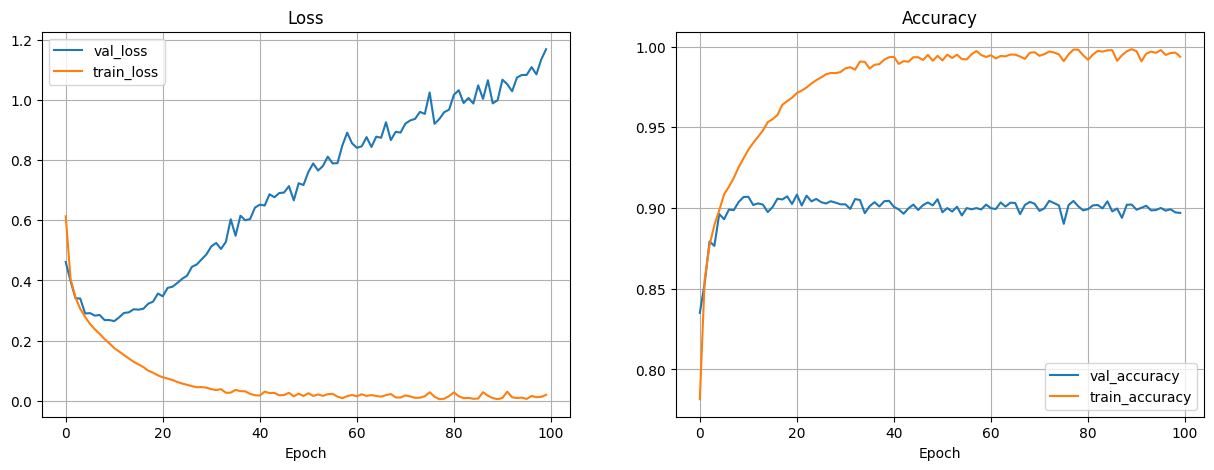

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))


print('History data: '+', '.join(history.history.keys()))
key_list = list(history.history.keys())

axes[0].plot(history.history[key_list[2]], label=key_list[2])
axes[0].plot(history.history[key_list[0]], label='train_' + key_list[0])
axes[0].grid('both')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend()

axes[1].plot(history.history[key_list[3]], label=key_list[3])
axes[1].plot(history.history[key_list[1]], label='train_' + key_list[1])
axes[1].grid('both')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].legend()

plt.show()

To save the model weights after training, use the `model.save_weights()` function.

In [26]:
save_path = 'log/model_ep{}'.format(len(history.history['loss']))  # set path where to save weights
if save_path:
    model.save_weights(save_path)
    print('Saved trained weights at {}'.format(save_path))

Saved trained weights at log/model_ep100


### Helper-functions to show performance

In [27]:
def print_confusion_matrix(model, images, labels):
    num_classes = 10
    # Get the predicted classifications for the test-set.
    predictions = model.predict(images)
    # Get the true classifications for the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(labels=labels,
    predictions = np.argmax(predictions,axis=1))
    # Print the confusion matrix as text.
    print(cm)
    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names, rotation=0)
    plt.ylim(num_classes-0.5,-0.5)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

Function for plotting examples of images from the test set that have been mis-classified.

In [28]:
def plot_example_errors(model, images, labels):
    # Get the predicted classifications for the test-set.
    predictions = model.predict(images)

    predictions_in = np.argmax(predictions, axis=1)
    correct = (predictions_in == labels)

    # Negate the boolean array.
    incorrect = (correct == False)
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = images[incorrect]
    # Get the predicted classes for those images.
    cls_pred = predictions_in[incorrect]
    # Get the true classes for those images.
    cls_true = labels[incorrect]
    # Plot the first 9 images.
    plot_images(images=images[0:9],
    labels=cls_true[0:9],
    predictions=cls_pred[0:9])

## Performance after 5 epochs

After 5 epochs, the model only mis-classifies a very few images. As demonstrated below, some of the mis-classifications are justified because the images are very hard to determine with certainty even for humans, while few examples are quite obvious but nevertheless the proposed 4-layer network fails. 

In [29]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

313/313 [==============================] - 2s 5ms/step - loss: 1.2424 - accuracy: 0.8950
Test accuracy: 0.8949999809265137


313/313 [==============================] - 1s 3ms/step


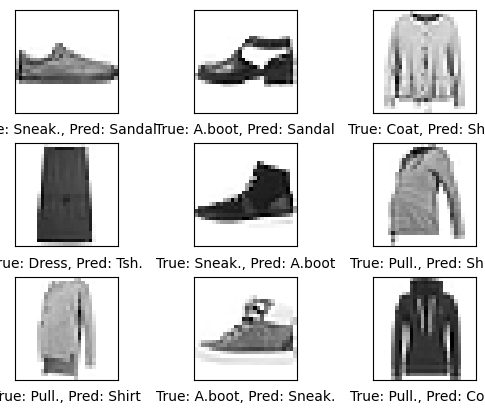

In [30]:
plot_example_errors(model, test_images, test_labels)

We can also print and plot the so-called confusion matrix which lets us see more details about the mis-classifications. 

313/313 [==============================] - 1s 3ms/step
tf.Tensor(
[[820   5  29  23   8   4 102   0   8   1]
 [  2 985   1   9   1   0   1   0   1   0]
 [ 21   2 871  10  37   0  57   1   1   0]
 [ 18  13  15 898  15   0  38   0   3   0]
 [  0   3  90  34 791   0  81   0   1   0]
 [  3   1   0   0   1 963   0  18   1  13]
 [ 92   0  78  31  40   0 751   0   8   0]
 [  0   0   0   0   0  17   0 958   1  24]
 [  5   2   4   4   3   2  15   5 957   3]
 [  1   0   0   0   0   9   1  33   0 956]], shape=(10, 10), dtype=int32)


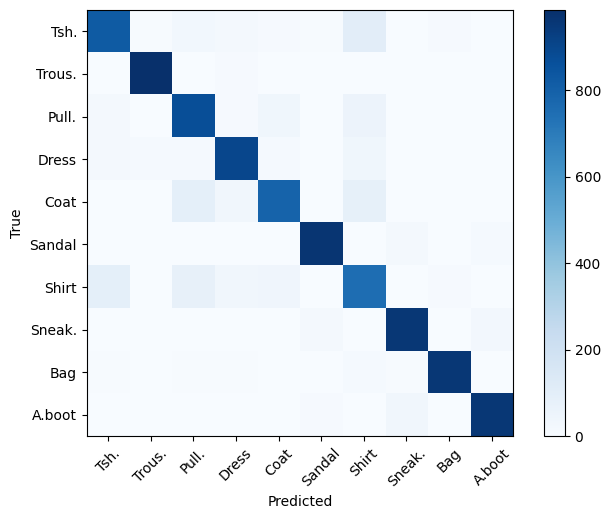

In [31]:
print_confusion_matrix(model, test_images, test_labels)

## Visualization of Weights and Layers
In trying to understand why the convolutional neural network can recognize handwritten digits, we will now visualize the weights of the convolutional
filters and the resulting output images.

## Helper-function for plotting convolutional weights

In [32]:
def plot_conv_weights(w, input_channel=0):
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)
    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]
    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids, figsize=(13,13))
    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]
            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
            interpolation='nearest', cmap='seismic')
            # Remove ticks from the plot.
            ax.set_xticks([])
            ax.set_yticks([])
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Helper-function for plotting the output of a convolutional layer

In [33]:
def plot_conv_layer(layer='conv1', image=None):
    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    if len(image.shape)==3:
        image = np.expand_dims(image,axis=0)
    intermediate_model = keras.models.Model(inputs=model.input, outputs=model.get_layer(layer).output)
    values = intermediate_model.predict(image)
    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]
    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids, figsize=(15,15))
    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]
            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
            # Remove ticks from the plot.
            ax.set_xticks([])
            ax.set_yticks([])
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Network Analysis
Given a input image, we are going to observe the ouput of the intermediate layers

## Input image
We pick an image from the test set.

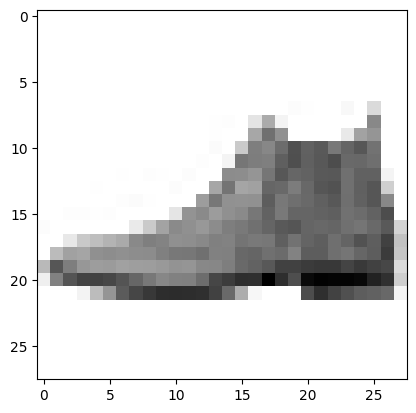

In [34]:
test_image = test_images[0]

plt.imshow(np.squeeze(test_image), interpolation='nearest', cmap='binary')
plt.show()

## First Convolutional Layer
Now, we plot the filter-weights for the first convolutional layer.

Note that positive weights are red and negative weights are blue.

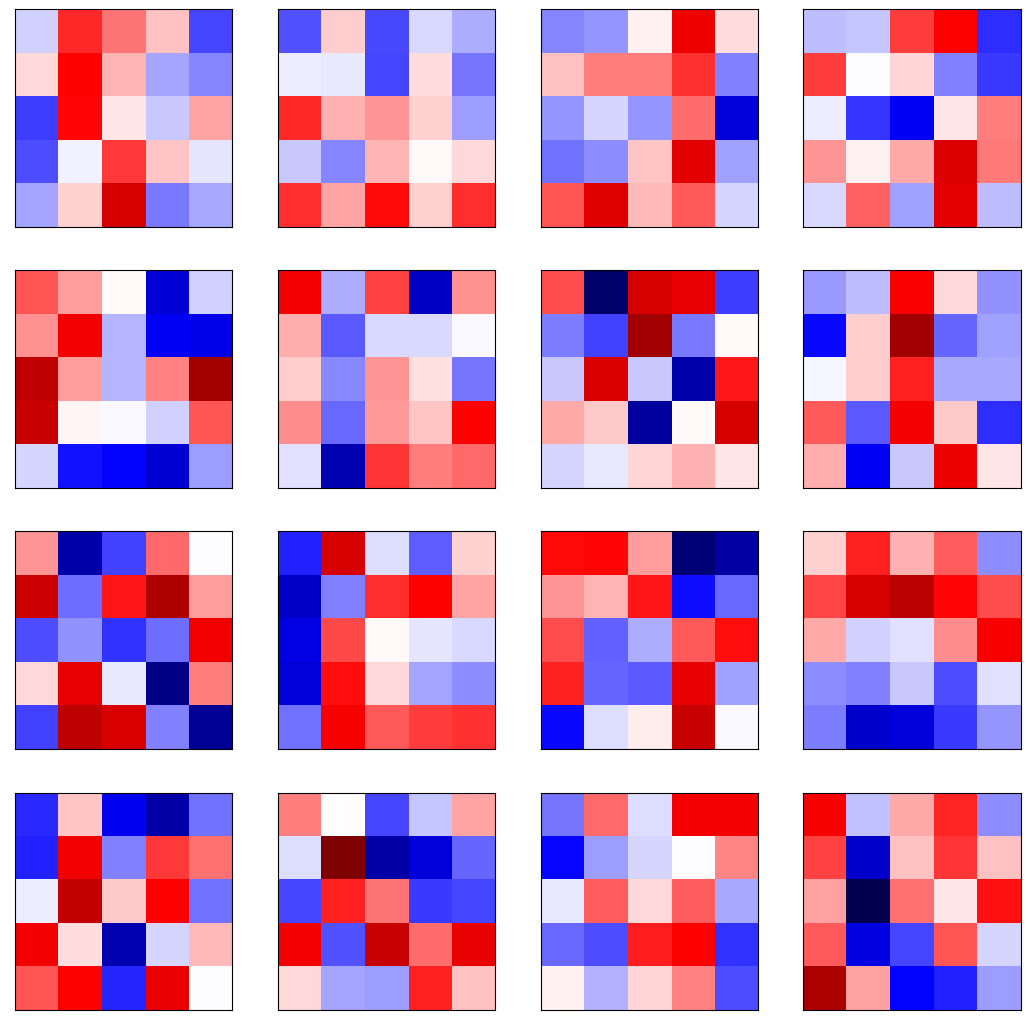

In [35]:
# Show weights Conv 1
w_conv1, b_conv1 = model.get_layer('conv2d').get_weights()
plot_conv_weights(w_conv1, input_channel=0)

Applying each of these convolutional filters to the first input image gives the following output images, which are then used as input to the second convolutional layer. Note that these images are downsampled to 14x14 pixels which is half the resolution of the original input image.

1/1 [==============================] - 0s 256ms/step


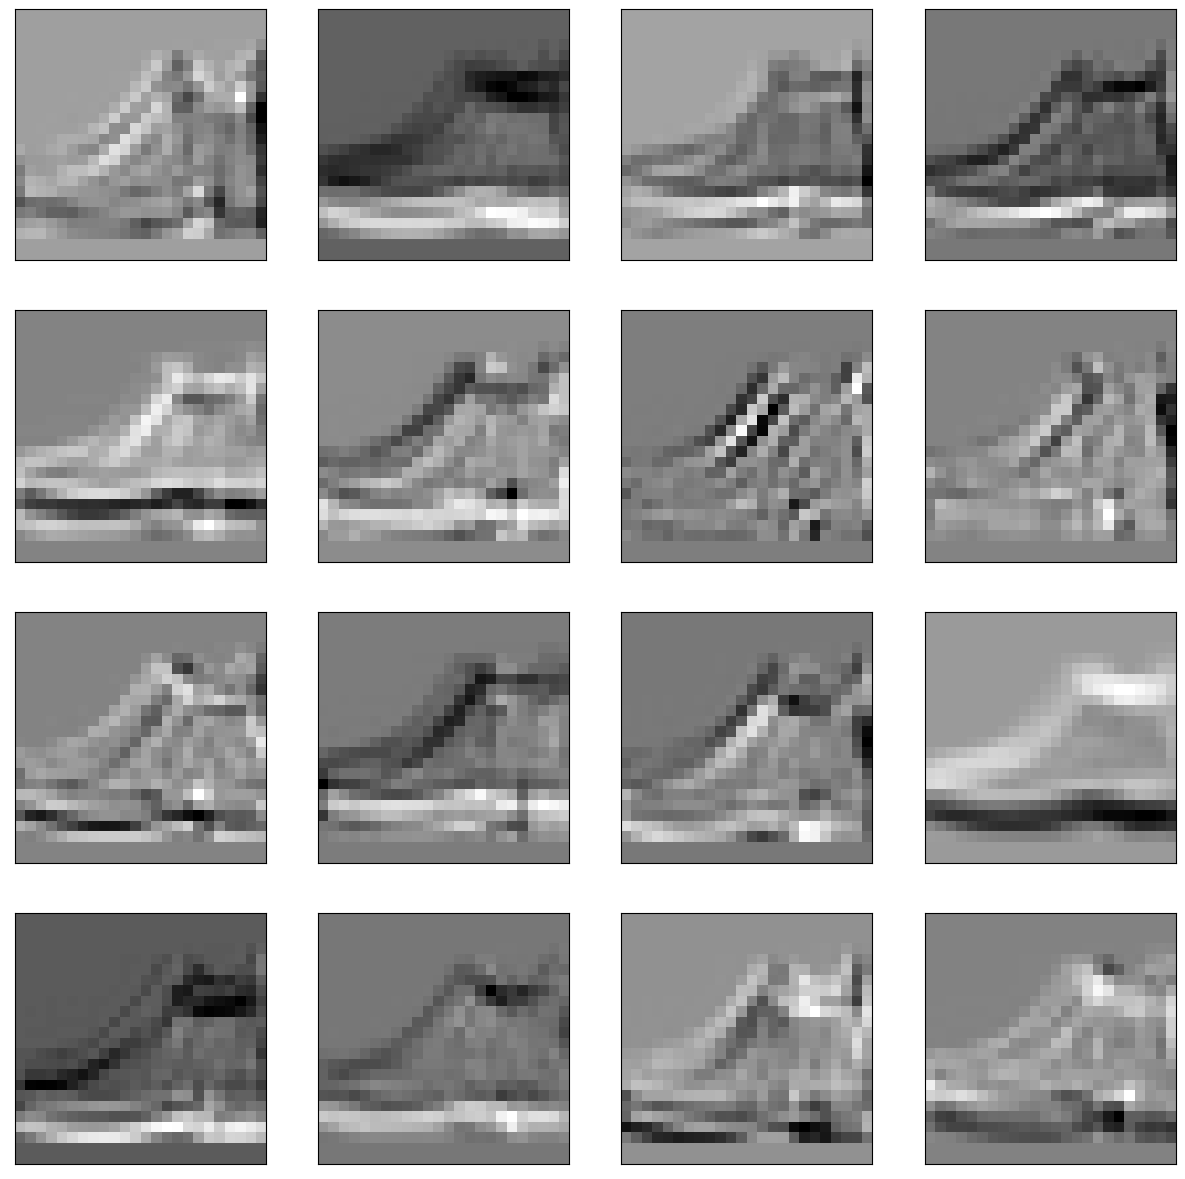

In [36]:
# Accepted values for layer are: 'input_1', 'conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'flatten', 'dense', 'dense_1'
plot_conv_layer(layer='conv2d', image=test_images[0])

It is difficult to see from these images what the purpose of the convolutional filters might be. It appears that they have merely created several variations of the input image, as if light was shining from different angles and casting shadows in the image.

## Second Convolutional Layer
Now plot the filter-weights for the second convolutional layer.

There are 16 output channels from the first conv-layer, which means there are 16 input channels to the second conv-layer. The second conv-layer has a set of filter-weights for each of its input channels. We start by plotting the filter-weigths for the first channel.

Note again that positive weights are red and negative weights are blue.

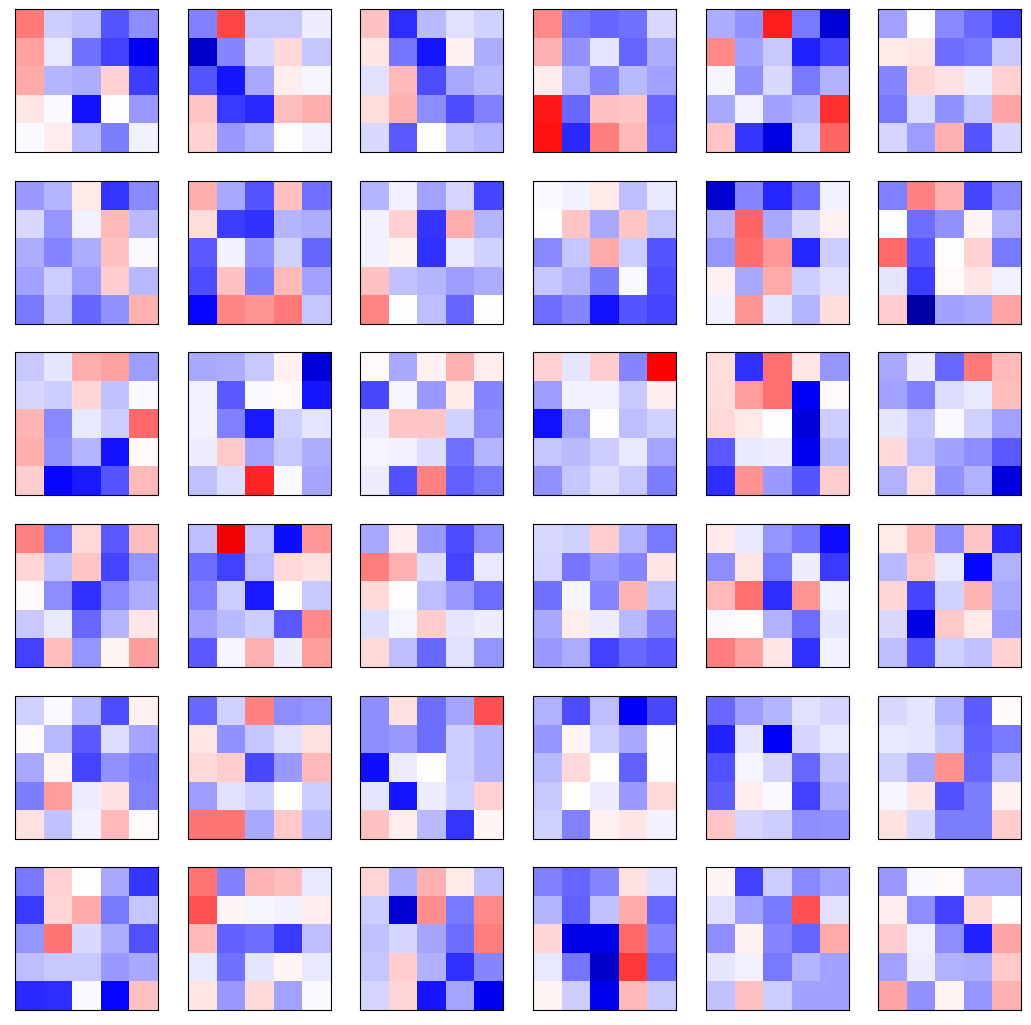

In [37]:
# Show weights Conv 2
w_conv2, b_conv2 = model.get_layer('conv2d_1').get_weights()
plot_conv_weights(w_conv2, input_channel=0)

There are 16 input channels to the second convolutional layer, so we can make another 15 plots of filter-weights like this. We just make one more with the filter-weights for the second channel.

It can be difficult to understand and keep track of how these filters are applied because of the high dimensionality.

Applying these convolutional filters to the images that were ouput from the first conv-layer gives the following images.

Note that these are downsampled yet again to 7x7 pixels which is half the resolution of the images from the first conv-layer.

1/1 [==============================] - 0s 247ms/step


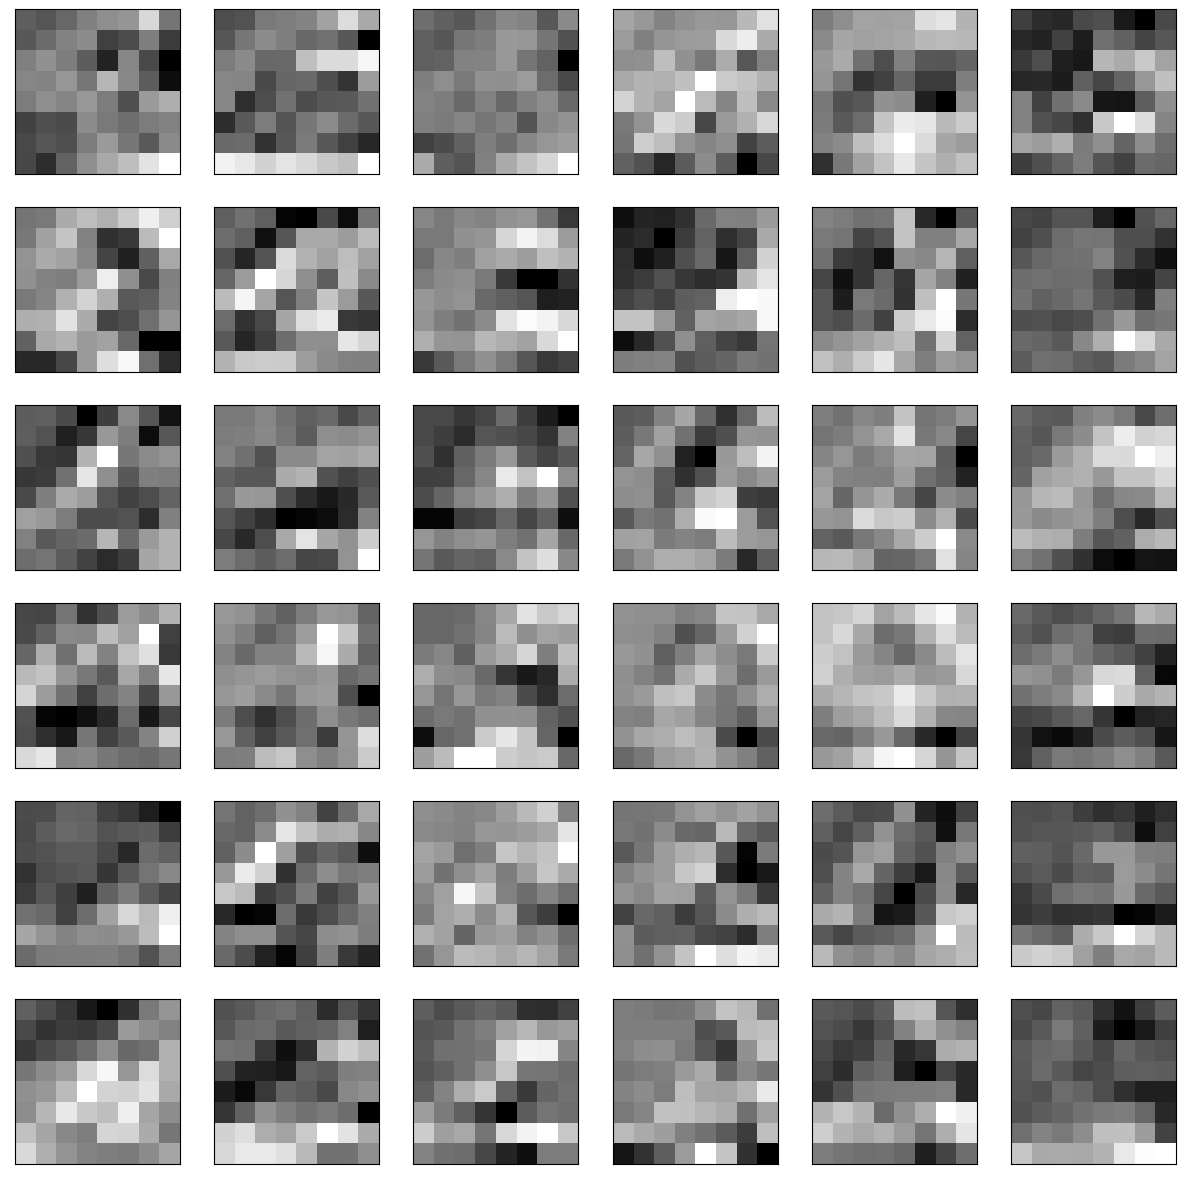

In [38]:
# Accepted values for layer are: 'input_1', 'conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'flatten', 'dense', 'dense_1'
plot_conv_layer(layer='conv2d_1', image=test_images[0])

From these images, it looks like the second convolutional layer might detect lines and patterns in the input images, which are less sensitive to local variations in the original input images.

These images are then flattened and input to the fully connected layer, but that is not shown here.

## Conclusion

We have seen how to implement a Convolutional Neural Network recognizing clothes. The Convolutional Network gets a classification accuracy of about 89%.





## License (MIT)

The tutorial has been adapted for the computer vision course and converted into the Keras framework by Gianluca Agresti.
Comments revised by P. Zanuttigh.

Based on the work from Magnus Erik Hvass Pedersen.

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Revised P. Zanuttigh

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.